In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005

epochs = 50
batch_size = 32

no_of_secondary_capsules = 10
checkpoint_path = './logs/model/capsule-10'

optimizer = tf.keras.optimizers.Adam()

In [3]:
(X_train, y_train), (X_test , y_test)= tf.keras.datasets.mnist.load_data()

In [4]:
X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

In [5]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [6]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        
        with tf.name_scope("Variables") as scope:
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')
        
    def build(self, input_shape):
        pass
        
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [7]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

model = CapsuleNetwork(**params)

In [8]:
def safe_norm(v, axis=-1):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [9]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

In [10]:
_ = model([X_train[:32], tf.one_hot(y_train[:32], depth=10)])

In [11]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_path)

In [12]:
y_test[:90]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1], dtype=uint8)

In [13]:
index_ = 4
index = 4

In [14]:
print(predict(model, tf.expand_dims(X_test[index_], axis=0)), y_test[index_])

[4] 4


In [15]:
features = model.predict_capsule_output(tf.expand_dims(X_test[index_], axis=0))

In [16]:
features.shape

TensorShape([1, 1, 10, 16])

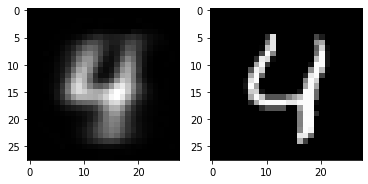

In [17]:
temp_features = features.numpy()
temp_ = temp_features.copy()
temp_features[:,:,:,:] = 0
temp_features[:,:,index,:] = temp_[:,:,index,:]

recon = model.regenerate_image(temp_features)
recon = tf.reshape(recon, (28,28))

plt.subplot(1,2,1)
plt.imshow(recon, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(X_test[index_,:,:,0], cmap='gray')

In [18]:
col = np.zeros((28,308))
for i in range(16): 
    feature_ = temp_features.copy()
    feature_[:,:,index, i] += -0.25
    row = np.zeros((28,28))
    for j in range(10):
        feature_[:,:,index, i] += 0.05
        row = np.hstack([row, tf.reshape(model.regenerate_image(tf.convert_to_tensor(feature_)), (28,28)).numpy()])
    col = np.vstack([col, row])

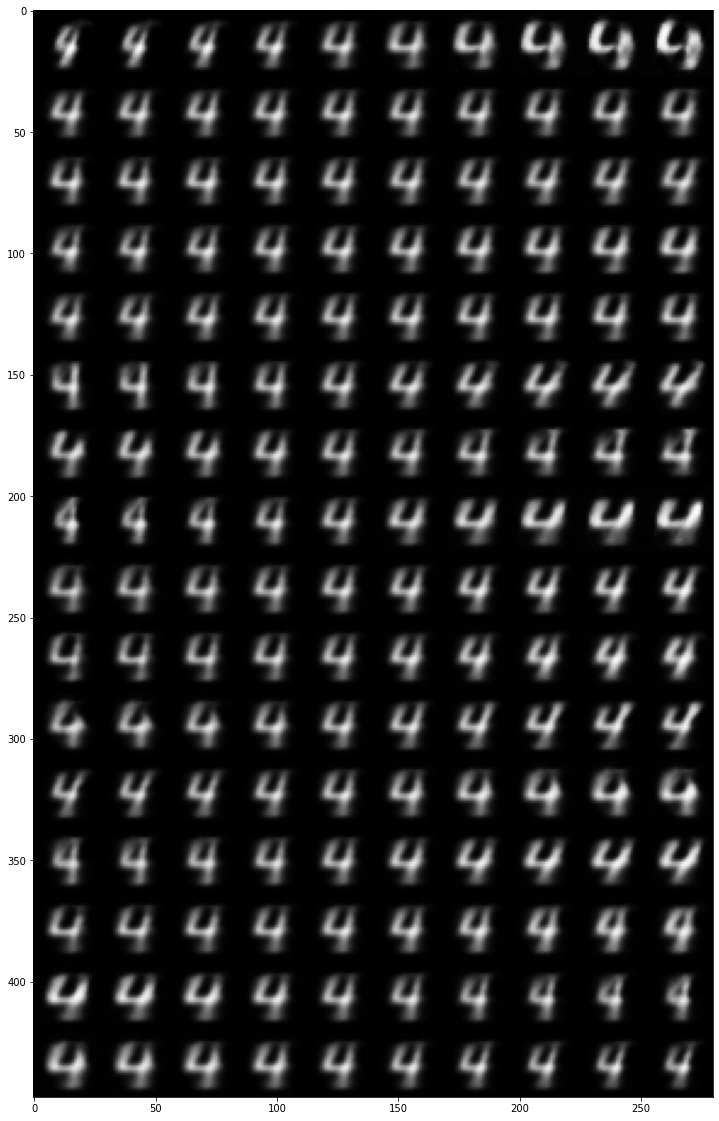

In [19]:
plt.figure(figsize=(30,20))
plt.imshow(col[28:, 28:], cmap='gray')